# Import Libraries

In [1]:
import requests
import os
import sklearn
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from pickle import dump
from sklearn.metrics import accuracy_score
import numpy as np 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
import nltk
from nltk.corpus import stopwords
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import warnings
import random

# Import Data

In [2]:
# URL of the CSV file
url = "https://raw.githubusercontent.com/4GeeksAcademy/naive-bayes-project-tutorial/main/playstore_reviews.csv"

# Destination file name
file_name = "comments.csv"

# Full path to the working directory
working_directory = "/workspaces/alfonsoMG_naive_bayes/data/raw/"

# Full path to the destination CSV file
file_path = os.path.join(working_directory, file_name)

# Download the CSV file from the URL
response = requests.get(url)

with open(file_path, 'wb') as file:
    file.write(response.content)

# Data Cleaning

In the process of implementing a Naive Bayes machine learning model for classifying comments as either negative or non-negative, the initial step following the importation of the .csv file involves a meticulous data cleaning phase. During this process, my focus will be on selectively retaining only those words deemed relevant for analysis, while excluding any symbols, numbers, or words with fewer than 3 letters.

This cleansing step is crucial to ensure the quality of the data used in training the model. By eliminating redundant or irrelevant information, I aim to ensure that the model concentrates on the fundamental aspects of the comments. This, in turn, should enhance its ability to discern between negative and non-negative comments more accurately and effectively.

In [3]:
# Path to the CSV file
csv_path = "/workspaces/alfonsoMG_naive_bayes/data/raw/comments.csv"

# Read the CSV file into a pandas DataFrame
df = pd.read_csv(csv_path)

# Display the first few rows of the DataFrame
df.head()

,package_name,review,polarity
0,com.facebook.katana,privacy at least put some option appear offli...,0
1,com.facebook.katana,"messenger issues ever since the last update, ...",0
2,com.facebook.katana,profile any time my wife or anybody has more ...,0
3,com.facebook.katana,the new features suck for those of us who don...,0
4,com.facebook.katana,forced reload on uploading pic on replying co...,0


In [4]:
# Drop the "package_name" column from the DataFrame
df.drop("package_name", axis=1, inplace=True)

# Display the first few rows of the modified DataFrame
df.head()

,review,polarity
0,privacy at least put some option appear offli...,0
1,"messenger issues ever since the last update, ...",0
2,profile any time my wife or anybody has more ...,0
3,the new features suck for those of us who don...,0
4,forced reload on uploading pic on replying co...,0


In [5]:
# Preprocess the "review" column
df["review"] = df["review"].str.lower().replace('[^\w\s\']', ' ', regex=True).str.split().apply(
    lambda x: ' '.join(filter(lambda word: word.isalpha() and len(word) > 2, x))
)

# Display the preprocessed "review" column for the first 40 rows
df["review"].head(40)

0     privacy least put some option appear offline m...
1     messenger issues ever since the last update in...
2     profile any time wife anybody has more than on...
3     the new features suck for those who have worki...
4     forced reload uploading pic replying comment l...
5     idk edit posts things such profile picture whe...
6     major flaws constant updates and always gettin...
7     video issues since was forced into this update...
8     this update completely destroyed facebook load...
9     posting issues for the last week been ghost po...
10    what the heck get status updates chronological...
11    its suck any time when want see something erro...
12    connection issues everytime try and click link...
13    external links are not working after updated l...
14    fix this please tried editing two profile pict...
15    buggy when edit post through the mobile app th...
16    connection issues app always says refresh now ...
17    get back facebook email thats wrong passwo

# Feature Selection

Following this, we will carry out the partitioning of our dataset into training and testing sets in preparation for model implementation. We have identified three primary alternatives for the Naive Bayes algorithm, and our approach involves applying our dataset to all three options. The intention is to compare the outcomes derived from each alternative comprehensively, enabling us to make informed decisions and take appropriate actions based on the observed results. This comparative analysis across multiple Naive Bayes models will contribute to a more robust understanding of how each variant performs in the context of our specific data, allowing us to select the most effective model for our classification task.

In [6]:
# Features (X) and target variable (y)
X = df["review"]
y = df["polarity"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

# Display the first few rows of the training set features
X_train.head()

68     after observation all above things should hate...
768                            errors and bugs app error
722    still not cool guys please this still not cool...
94     facebook ripoff used see connections new conne...
640    too many useless features does anybody actuall...
Name: review, dtype: object

In [7]:
X_train.to_csv("/workspaces/alfonsoMG_naive_bayes/data/processed/X_train.csv")
X_test.to_csv("/workspaces/alfonsoMG_naive_bayes/data/processed/X_test.csv")
y_train.to_csv("/workspaces/alfonsoMG_naive_bayes/data/processed/y_train.csv")
y_test.to_csv("/workspaces/alfonsoMG_naive_bayes/data/processed/y_test.csv")

# Model Training

In [8]:
# Download the NLTK stopwords for English
nltk.download('stopwords')

# Create a list of stopwords
stop_words = list(stopwords.words('english'))

# Initialize CountVectorizer with stop_words
vec_model = CountVectorizer(stop_words=stop_words)

# Convert the training set text data into a bag-of-words representation
X_train = vec_model.fit_transform(X_train).toarray()

# Convert the testing set text data into a bag-of-words representation
X_test = vec_model.transform(X_test).toarray()

[nltk_data] Downloading package stopwords to /home/vscode/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
# Suppress specific FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Suppress specific UserWarnings
warnings.simplefilter(action='ignore', category=UserWarning)

# Suppress FitFailedWarning from scikit-learn
warnings.filterwarnings("ignore", category=sklearn.exceptions.FitFailedWarning)

In [10]:
models = [
    (GaussianNB(), "Gaussian"),
    (MultinomialNB(), "Multinomial"),
    (BernoulliNB(), "Bernoulli")
]

min_difference = float('inf')
best_model_name = ''

for model, name in models:
    model.fit(X_train, y_train)
    
    # Save the trained model to a file
    model_file = f"/workspaces/alfonsoMG_naive_bayes/models/model_{name.lower()}.pk"
    dump(model, open(model_file, "wb"))

    # Evaluate and print training accuracy
    y_pred_train = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_pred_train)
    print(f"{name} Train Accuracy: {train_accuracy}")

    # Evaluate and print testing accuracy
    y_pred_test = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred_test)
    print(f"{name} Test Accuracy: {test_accuracy}")

    # Calculate and print accuracy difference
    accuracy_difference = abs(train_accuracy - test_accuracy)
    print(f"{name} Accuracy Difference: {accuracy_difference}\n")

    # Update best model information if the current model has a smaller difference
    if accuracy_difference < min_difference:
        min_difference = accuracy_difference
        best_model_name = name

# Print the best model information
print(f"The best model is: {best_model_name} with the smallest difference ({min_difference:.4f}) between train and test accuracy.")

Gaussian Train Accuracy: 0.9859550561797753
Gaussian Test Accuracy: 0.7597765363128491
Gaussian Accuracy Difference: 0.22617851986692616

Multinomial Train Accuracy: 0.9564606741573034
Multinomial Test Accuracy: 0.8659217877094972
Multinomial Accuracy Difference: 0.09053888644780617

Bernoulli Train Accuracy: 0.9213483146067416
Bernoulli Test Accuracy: 0.7486033519553073
Bernoulli Accuracy Difference: 0.17274496265143435

The best model is: Multinomial with the smallest difference (0.0905) between train and test accuracy.


# Optimization

In the next step, we will perform a grid search across hyperparameters to address the issue of overfitting and/or enhance accuracy. This systematic exploration of hyperparameter combinations aims to fine-tune the model's performance, seeking optimal parameter values that contribute to mitigating overfitting while potentially improving overall accuracy. Grid search allows us to exhaustively evaluate various hyperparameter configurations, providing insights into the parameter values that yield the best results for our specific machine learning task. The ultimate goal is to optimize the model's generalization to new data and achieve better predictive performance.

In [11]:
# Define hyperparameter grid
hyperparams = {
    "alpha": [0] + list(np.arange(1.0, 10, 0.1)),  
    "fit_prior": [True, False],
    "class_prior": [None, np.arange(0.1, 1, 10)]
}

# Initialize Multinomial Naive Bayes model
multinomial = MultinomialNB()

# Perform GridSearchCV to find the best hyperparameters
grid = GridSearchCV(multinomial, hyperparams, scoring='accuracy', cv=5)
grid.fit(X_train, y_train)

# Get the best hyperparameters
best_hyper = grid.best_params_

# Initialize the best Multinomial Naive Bayes model with the optimal hyperparameters
best_model = MultinomialNB(**best_hyper)
best_model.fit(X_train, y_train)

# Evaluate and print the accuracy score for the training set
y_pred_train = best_model.predict(X_train)
train_score = accuracy_score(y_train, y_pred_train)
print(f"The accuracy score for Train is : {train_score}")

# Evaluate and print the accuracy score for the testing set
y_pred_test = best_model.predict(X_test)
test_score = accuracy_score(y_test, y_pred_test)
print(f"The accuracy score for Test is : {test_score}")

# Print the difference between training and testing accuracy
print(f"Train/Test difference: {train_score - test_score}")

# Save the optimized Multinomial Naive Bayes model to a file
dump(best_model, open(f"/workspaces/alfonsoMG_naive_bayes/models/opt_multinomial.pk", "wb"))


The accuracy score for Train is : 0.9424157303370787
The accuracy score for Test is : 0.8659217877094972
Train/Test difference: 0.07649394262758147


### *Confusion Matrix*

To conclude the project, I have visually represented the confusion matrix, which provides insights into both true positives and negatives, as well as false positives and negatives. This matrix serves as a comprehensive summary of the model's performance, allowing us to assess how well it has correctly classified instances and where potential misclassifications may have occurred. By examining the elements of the confusion matrix, we can gain a clear understanding of the model's strengths and weaknesses, particularly in distinguishing between positive and negative instances. This visual representation will serve as a valuable tool for the final evaluation of the Naive Bayes models and inform any necessary adjustments or conclusions drawn from the project.

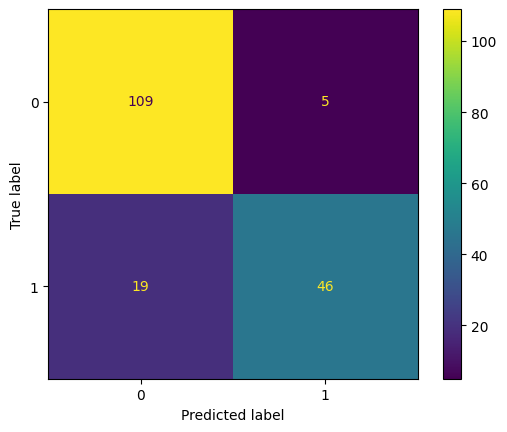

In [12]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_test)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot()


# Conclusion

My conclusion revolves primarily around the issue of overfitting. It is well-known that overfitting is a concern, and therefore, the objective should be to mitigate it. In this case, despite achieving relatively high results in both training and testing, a significant overfitting challenge persists. While you've made strides in reducing and improving overfitting through hyperparameter optimization, it seems that further improvement is still needed. Instead of solely continuing to fine-tune hyperparameters, considering a review of the data cleaning process might be worthwhile.

Given that this project serves educational purposes, you've decided to move on to the next project for now. It's a strategic decision to explore different aspects and challenges in subsequent projects, possibly gaining new insights that could be applied to revisit and enhance the current Naive Bayes classification project in the future.